In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn
import pandas as pd
import numpy as np
import pystan
import scipy
import sys
sys.path.append("..")
import bayesian_anova

In [2]:
cols = ['experiment_name',
        'test_acc',
        'train_time',
        'entropy__auc',
        'entropy_expectation__auc',
        'classifier__auc']

In [3]:
experiments = ['convolutional', 'convolutional-dropout']#, 'convolutional-poor-bayesian']

In [4]:
dfs = []
for exp in experiments:
    df_with = pd.read_csv(exp+'_with_unknown.csv')
    df_with_results = df_with[cols].set_index('experiment_name') #df_with.groupby(['inside_labels', 'unknown_labels']).mean()[cols]
    df_without = pd.read_csv(exp+'_out_unknown.csv')
    df_without_results = df_without[cols].set_index('experiment_name') #df_without.groupby(['inside_labels', 'unknown_labels']).mean()[cols]
    dfs.append([exp, df_with_results, df_without_results])

In [5]:
results_cols = ['experiment',
                'in_test_acc', 'out_test_acc',
                'in_train_time', 'out_train_time',
                'in_entropy_auc', 'out_entropy_auc',
                'in_entropy_expectation_auc', 'out_entropy_expectation_auc',
                'in_classifier_auc', 'out_classifier_auc']

dfs_results = []
for exp, df_with, df_without in dfs:
    results = pd.DataFrame(columns=results_cols)
    for (in_key, *in_row), (out_key, *out_row) in zip(df_with.itertuples(), df_without.itertuples()):
        assert in_key == out_key
        results.loc[len(results)] = [
            str(in_key),
            in_row[0], out_row[0],
            in_row[1], out_row[1],
            in_row[2], out_row[2],
            in_row[3], out_row[3],
            in_row[4], out_row[4],
        ]
    dfs_results.append([exp, results])

In [6]:
final_results_cols = ['experiment']
for c in results_cols[1:]:
    for exp, _ in dfs_results:
        final_results_cols.append(exp+'_'+c)

In [7]:
final_results = pd.DataFrame(columns=final_results_cols)
for key_row in zip(*[df.itertuples() for exp, df in dfs_results]):
    for i in range(1, len(key_row)):
        _, *prev_row = key_row[i-1]
        _, *row = key_row[i]
        assert prev_row[0] == row[0]
        
    _, *row = key_row[0]
    new_row = [row[0]]
    
    for c in range(1, len(results_cols)):
        for _, *row in key_row:
            new_row.append(row[c])

    final_results.loc[len(final_results)] = new_row

In [8]:
model = pystan.StanModel(model_code=bayesian_anova.one_way_code)

In [9]:
out_acc = ['convolutional_out_classifier_auc', 'convolutional-dropout_out_classifier_auc']#, 'convolutional-poor-bayesian_out_classifier_auc']
#out_acc = ['convolutional_out_entropy_auc', 'convolutional-dropout_out_entropy_auc', 'convolutional-poor-bayesian_out_entropy_auc']
y_out = final_results[out_acc].values
y_out = scipy.special.logit(y_out)

in_acc = ['convolutional_in_classifier_auc', 'convolutional-dropout_in_classifier_auc']#, 'convolutional-poor-bayesian_in_classifier_auc']
#in_acc = ['convolutional_in_entropy_auc', 'convolutional-dropout_in_entropy_auc', 'convolutional-poor-bayesian_in_entropy_auc']
y_in = final_results[in_acc].values
y_in = scipy.special.logit(y_in)

Inference for Stan model: anon_model_898d35be2ee751b9d94e0bc0eaa1393c.
4 chains, each with iter=10000; warmup=5000; thin=5; 
post-warmup draws per chain=1000, total post-warmup draws=4000.

                   mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
mu                 2.41  4.5e-4   0.03   2.36   2.39   2.41   2.43   2.47   4000    1.0
theta_free[0]     -0.06  4.6e-4   0.03  -0.12  -0.08  -0.06  -0.04-3.6e-3   4000    1.0
sigma_likelihood    0.4  3.2e-4   0.02   0.36   0.39    0.4   0.42   0.44   4000    1.0
sigma_theta         6.0    0.22  13.68   0.03   0.23   1.14    5.7  39.34   4000    1.0
theta[0]          -0.06  4.6e-4   0.03  -0.12  -0.08  -0.06  -0.04-3.6e-3   4000    1.0
theta[1]           0.06  4.6e-4   0.03 3.6e-3   0.04   0.06   0.08   0.12   4000    1.0
lp__              81.71    0.02   1.32  78.46  81.07  82.04  82.69  83.29   4000    1.0

Samples were drawn using NUTS(diag_e) at Sat Oct 29 15:37:16 2016.
For each parameter, n_eff is a crude m

/Users/roliveira/anaconda3/lib/python3.5/multiprocessing/reduction.py:50: UserWarning: Pickling fit objects is an experimental feature!
The relevant StanModel instance must be pickled along with this fit object.
When unpickling the StanModel must be unpickled first.
  cls(buf, protocol).dump(obj)
/Users/roliveira/anaconda3/lib/python3.5/multiprocessing/reduction.py:50: UserWarning: Pickling fit objects is an experimental feature!
The relevant StanModel instance must be pickled along with this fit object.
When unpickling the StanModel must be unpickled first.
  cls(buf, protocol).dump(obj)
/Users/roliveira/anaconda3/lib/python3.5/multiprocessing/reduction.py:50: UserWarning: Pickling fit objects is an experimental feature!
The relevant StanModel instance must be pickled along with this fit object.
When unpickling the StanModel must be unpickled first.
  cls(buf, protocol).dump(obj)
/Users/roliveira/anaconda3/lib/python3.5/multiprocessing/reduction.py:50: UserWarning: Pickling fit object

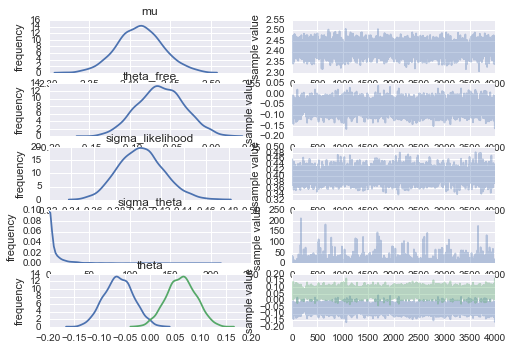

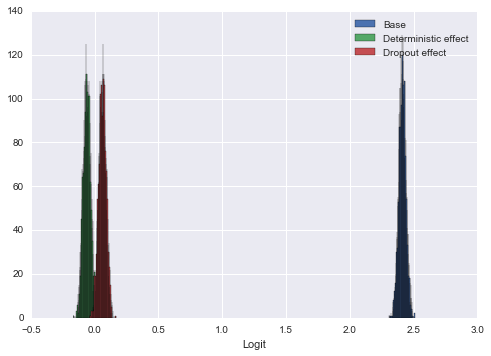

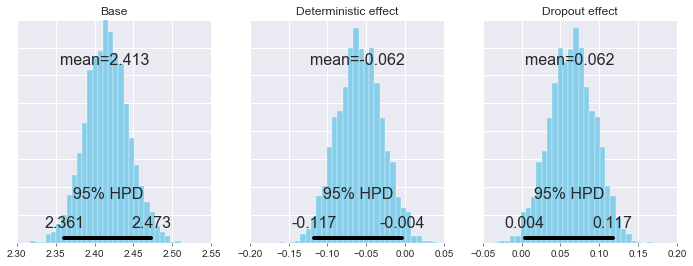

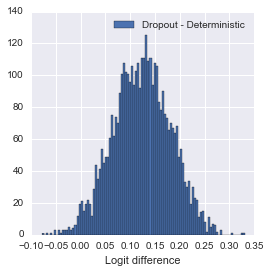

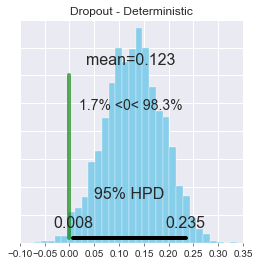

Dropout - Deterministic 95.0 CI: 0.0072305639529 0.23412487773 Pr > 0: 0.983
Inference for Stan model: anon_model_898d35be2ee751b9d94e0bc0eaa1393c.
4 chains, each with iter=10000; warmup=5000; thin=5; 
post-warmup draws per chain=1000, total post-warmup draws=4000.

                   mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
mu                 2.18  2.2e-4   0.01   2.15   2.17   2.18   2.19    2.2   4000    1.0
theta_free[0]     -0.09  2.3e-4   0.01  -0.12   -0.1  -0.09  -0.08  -0.07   4000    1.0
sigma_likelihood   0.21  1.6e-4   0.01   0.19    0.2   0.21   0.21   0.23   4000    1.0
sigma_theta        6.62    0.31  19.41   0.07   0.34   1.48   6.27  40.16   4000    1.0
theta[0]          -0.09  2.3e-4   0.01  -0.12   -0.1  -0.09  -0.08  -0.07   4000    1.0
theta[1]           0.09  2.3e-4   0.01   0.07   0.08   0.09    0.1   0.12   4000    1.0
lp__             215.01    0.02   1.28 211.64 214.42 215.33 215.95 216.54   4000    1.0

Samples were drawn using NUT

/Users/roliveira/anaconda3/lib/python3.5/multiprocessing/reduction.py:50: UserWarning: Pickling fit objects is an experimental feature!
The relevant StanModel instance must be pickled along with this fit object.
When unpickling the StanModel must be unpickled first.
  cls(buf, protocol).dump(obj)
/Users/roliveira/anaconda3/lib/python3.5/multiprocessing/reduction.py:50: UserWarning: Pickling fit objects is an experimental feature!
The relevant StanModel instance must be pickled along with this fit object.
When unpickling the StanModel must be unpickled first.
  cls(buf, protocol).dump(obj)
/Users/roliveira/anaconda3/lib/python3.5/multiprocessing/reduction.py:50: UserWarning: Pickling fit objects is an experimental feature!
The relevant StanModel instance must be pickled along with this fit object.
When unpickling the StanModel must be unpickled first.
  cls(buf, protocol).dump(obj)
/Users/roliveira/anaconda3/lib/python3.5/multiprocessing/reduction.py:50: UserWarning: Pickling fit object

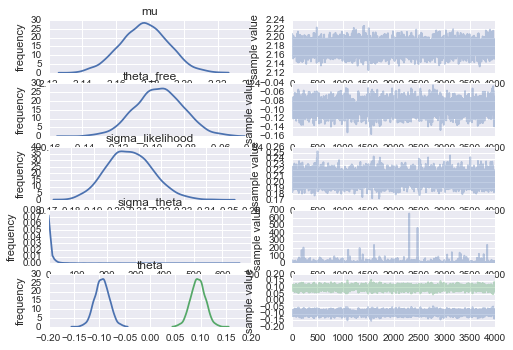

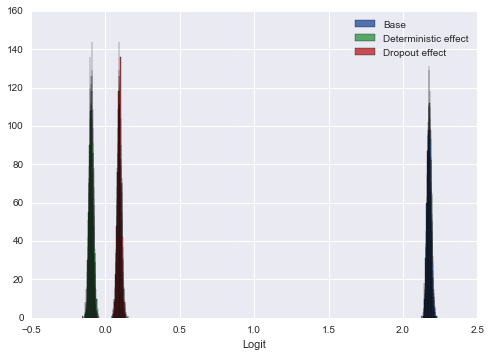

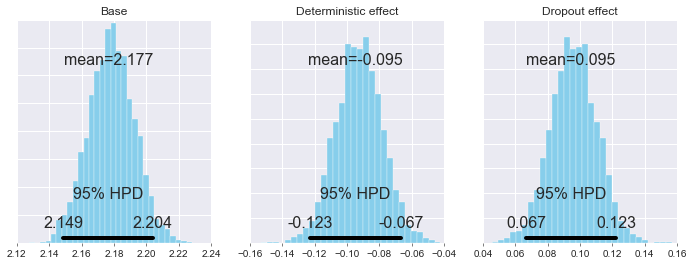

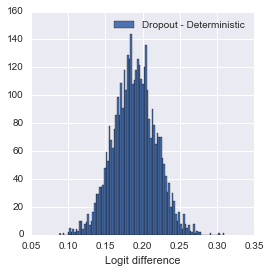

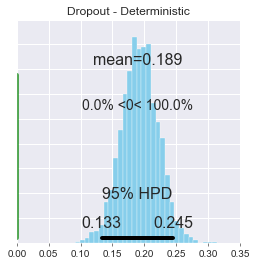

Dropout - Deterministic 95.0 CI: 0.133290077123 0.245162236069 Pr > 0: 1.0


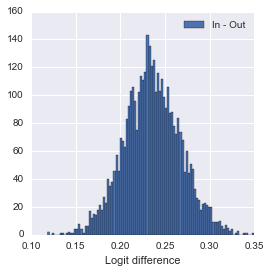

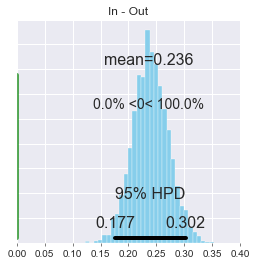

In - Out 95.0 CI: 0.173342912275 0.300551054104 Pr > 0: 1.0


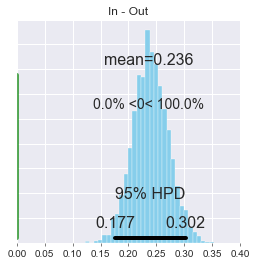

In [10]:
for y in [y_in, y_out]:
    (N, K) = y.shape

    data = {'K': K, 'N': N, 'y': y}
    fit = model.sampling(data=data, iter=10000, chains=4, thin=5)
    
    bayesian_anova.show_results(fit)
    
    trace = fit.extract()
    deterministic = trace['theta'][:,0]
    dropout = trace['theta'][:,1]
    #poor_bayesian = trace['theta'][:,2]
    base_mean = trace['mu']
    
    if y is y_in:
        in_mean = np.copy(base_mean)
    else:
        out_mean = np.copy(base_mean)

    bayesian_anova.plot_traces([base_mean, deterministic, dropout],# poor_bayesian],
                               ["Base", "Deterministic effect", "Dropout effect"])#, "OneSample Bayesian effect"])

    bayesian_anova.effect_difference(dropout, deterministic, 'Dropout', 'Deterministic')
    #bayesian_anova.effect_difference(poor_bayesian, deterministic, 'OneSample Bayesian', 'Deterministic')
    #bayesian_anova.effect_difference(poor_bayesian, dropout, 'OneSample Bayesian', 'Dropout')

bayesian_anova.effect_difference(in_mean, out_mean, 'In', 'Out')